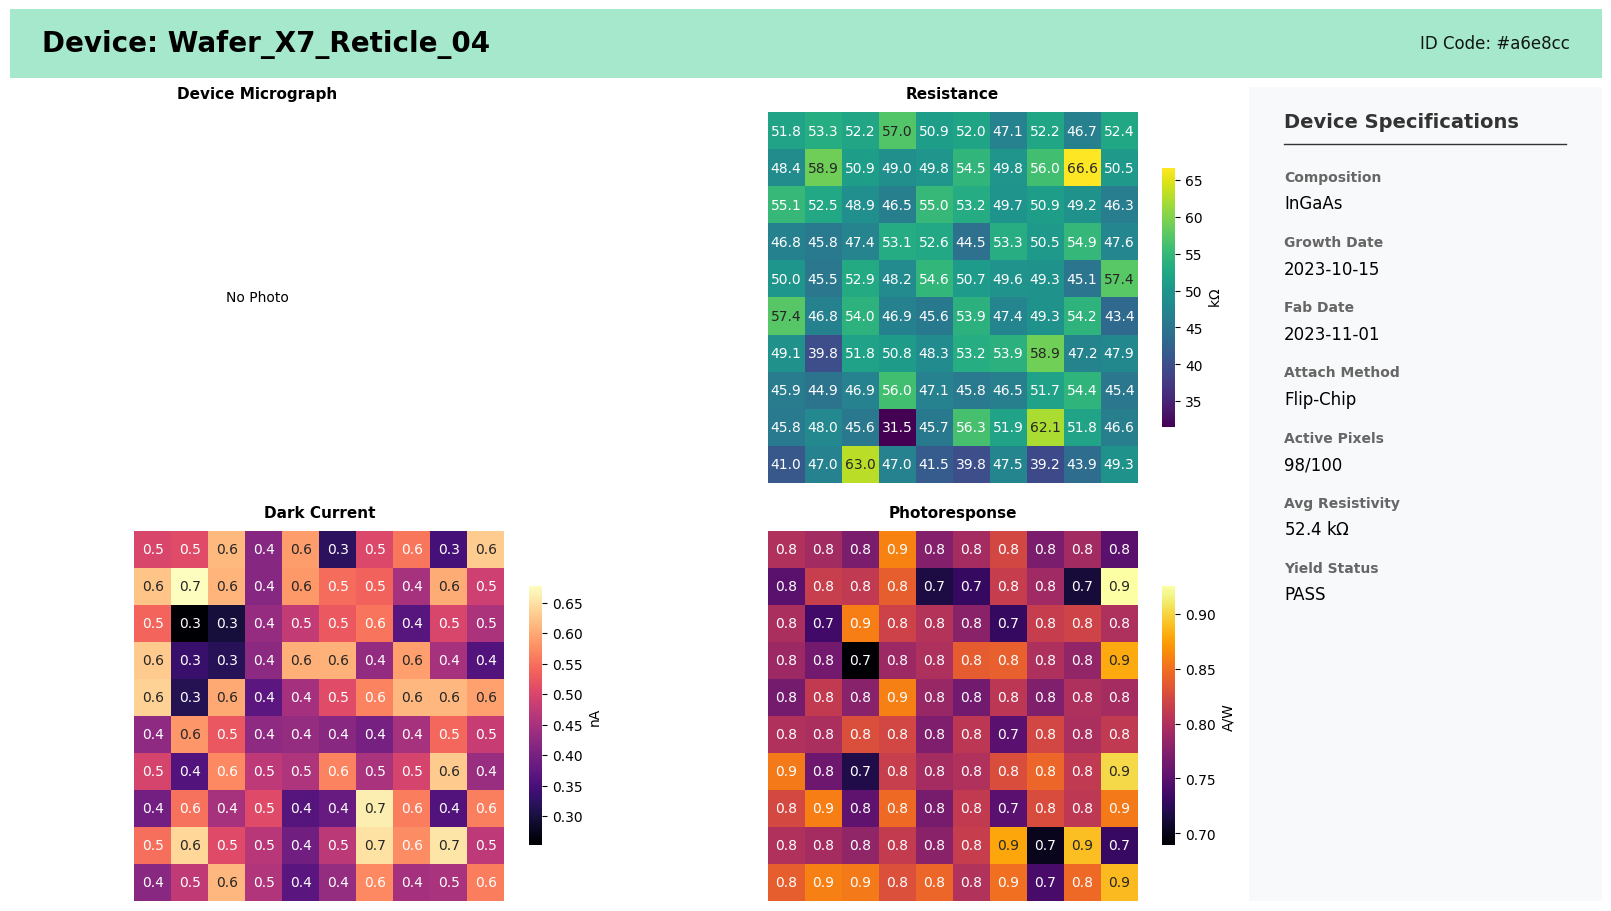

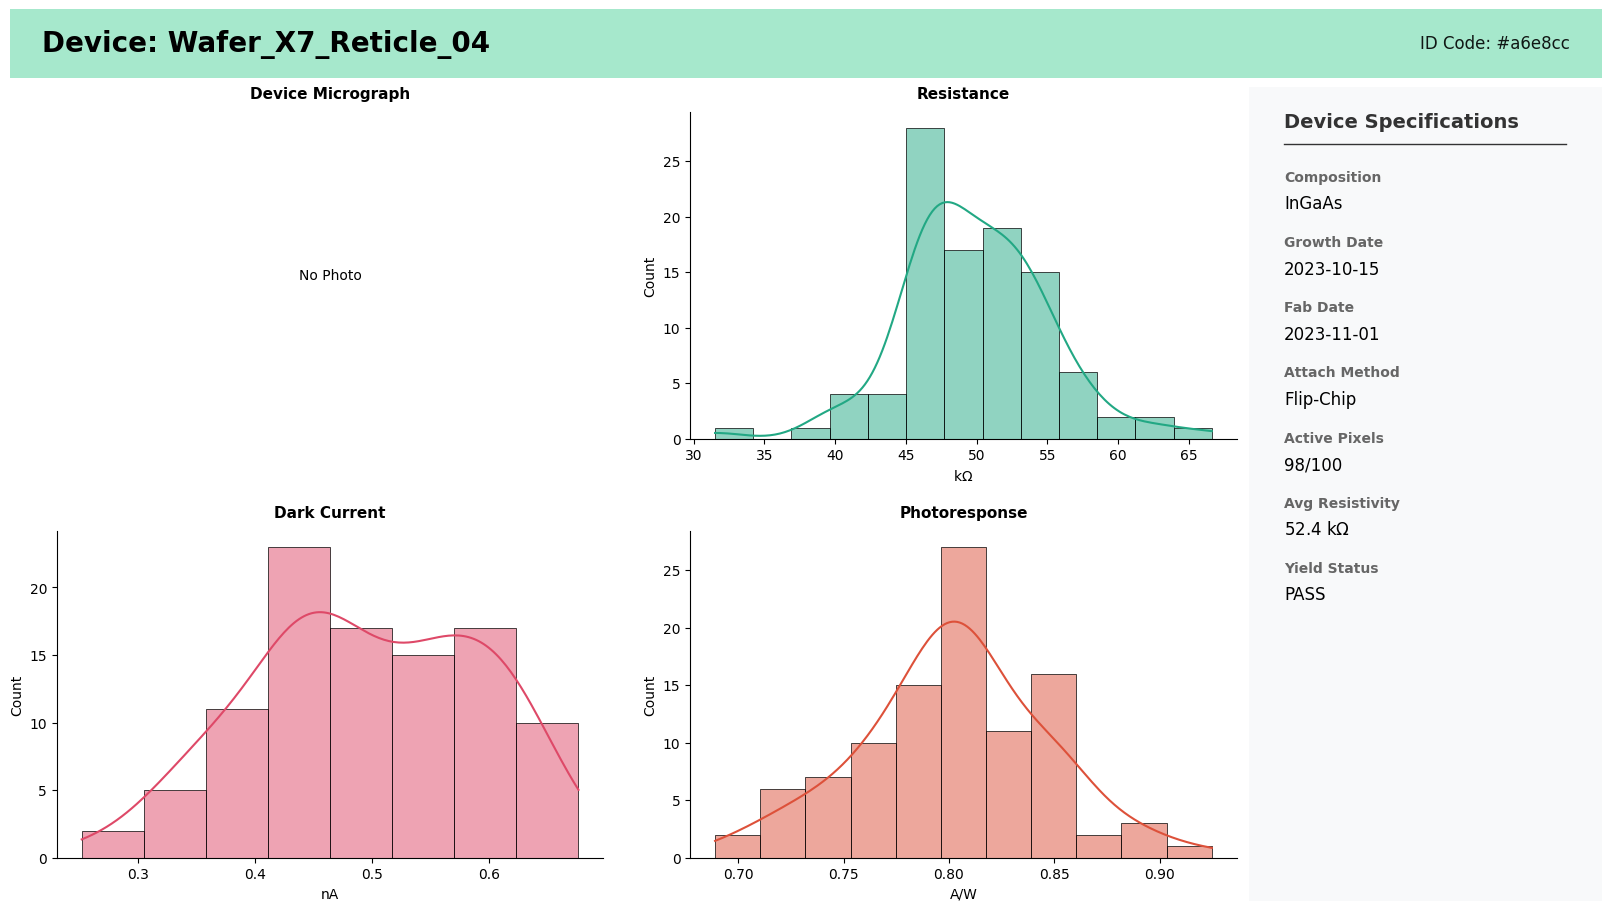

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import hashlib

class DeviceReportGenerator:
    def __init__(self, device_id, photo_path=None, metadata=None):
        self.device_id = device_id
        self.photo_path = photo_path
        self.metadata = metadata if metadata else {}
        self.id_color = self._generate_id_color(device_id)
        self.text_color = self._get_contrast_text_color(self.id_color)

    def _generate_id_color(self, input_string):
        hash_object = hashlib.md5(input_string.encode())
        return f"#{hash_object.hexdigest()[:6]}"

    def _get_contrast_text_color(self, hex_color):
        hex_color = hex_color.lstrip('#')
        r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        return '#000000' if ((0.299 * r + 0.587 * g + 0.114 * b) / 255) > 0.5 else '#ffffff'

    def generate_report(self, res_data, dark_data, photo_data, plot_type='heatmap'):
        # 1. Setup Canvas: Standard Slide Resolution (16:9 aspect ratio)
        fig = plt.figure(figsize=(16, 9), constrained_layout=True)
        
        # 2. Grid Structure
        # Height: Header is small (1), Content is large (12)
        gs_master = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 12])

        # --- HEADER (Top Bar) ---
        ax_header = fig.add_subplot(gs_master[0, 0])
        ax_header.set_facecolor(self.id_color)
        ax_header.set_xticks([])
        ax_header.set_yticks([])
        # Remove the spine border for a cleaner look
        for spine in ax_header.spines.values():
            spine.set_visible(False)
            
        ax_header.text(0.02, 0.5, f"Device: {self.device_id}", 
                       transform=ax_header.transAxes, va='center', ha='left',
                       fontsize=20, fontweight='bold', color=self.text_color)
        
        ax_header.text(0.98, 0.5, f"ID Code: {self.id_color}", 
                       transform=ax_header.transAxes, va='center', ha='right',
                       fontsize=12, color=self.text_color, alpha=0.9)

        # --- CONTENT AREA (Bottom) ---
        # Left side (Images) = 75% width, Right side (Data) = 25% width
        gs_content = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_master[1, 0], 
                                                      width_ratios=[3.5, 1])

        # --- LEFT: VISUALS (2x2 Grid) ---
        gs_visuals = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_content[0, 0],
                                                      wspace=0.05, hspace=0.05)

        # 1. Photo
        ax_img = fig.add_subplot(gs_visuals[0, 0])
        if self.photo_path:
            try:
                img = plt.imread(self.photo_path)
                ax_img.imshow(img)
            except FileNotFoundError:
                self._plot_placeholder(ax_img, "Image Missing")
        else:
            self._plot_placeholder(ax_img, "No Photo")
        ax_img.set_title("Device Micrograph", fontsize=11, fontweight='bold', pad=10)
        ax_img.axis('off')

        # 2, 3, 4: Data Plots
        plot_configs = [
            (res_data, "Resistance", "k$\\Omega$", "viridis", gs_visuals[0, 1]),
            (dark_data, "Dark Current", "nA", "magma", gs_visuals[1, 0]),
            (photo_data, "Photoresponse", "A/W", "inferno", gs_visuals[1, 1])
        ]

        for data, title, unit, cmap, pos in plot_configs:
            ax = fig.add_subplot(pos)
            
            if plot_type == 'heatmap':
                # 'square=True' forces 1:1 pixel ratio
                # 'cbar_kws={"shrink": 0.7}' prevents colorbar from being taller than the plot
                sns.heatmap(data, ax=ax, cmap=cmap, annot=True, fmt=".1f", 
                            square=True, cbar=True, cbar_kws={'label': unit, 'shrink': 0.7})
                ax.set_xticks([]) # Clean up ticks for cleaner look
                ax.set_yticks([])
            
            elif plot_type == 'histogram':
                sns.histplot(data.flatten(), ax=ax, kde=True, 
                             color=plt.get_cmap(cmap)(0.6), edgecolor='black', linewidth=0.5)
                ax.set_xlabel(unit)
                ax.set_ylabel("Count")
                sns.despine(ax=ax)

            ax.set_title(f"{title}", fontsize=11, fontweight='bold', pad=10)

        # --- RIGHT: METADATA SIDEBAR ---
        ax_meta = fig.add_subplot(gs_content[0, 1])
        ax_meta.set_facecolor('#f8f9fa') # Very light grey
        ax_meta.set_xticks([])
        ax_meta.set_yticks([])
        for spine in ax_meta.spines.values():
            spine.set_visible(False)

        # Title of Sidebar
        ax_meta.text(0.1, 0.95, "Device Specifications", transform=ax_meta.transAxes,
                     fontsize=14, fontweight='bold', color='#333333')
        
        # Decorative line
        ax_meta.plot([0.1, 0.9], [0.93, 0.93], transform=ax_meta.transAxes, 
                     color='#333333', linewidth=1)

        # Dynamic Text Placement
        # We start at Y=0.88 and move down by step size
        start_y = 0.88
        step_y = 0.08 # Distance between items
        
        for i, (key, value) in enumerate(self.metadata.items()):
            current_y = start_y - (i * step_y)
            
            # KEY (Label)
            ax_meta.text(0.1, current_y, f"{key}", transform=ax_meta.transAxes,
                         fontsize=10, fontweight='bold', color='#666666', va='bottom')
            
            # VALUE (Data) - placed slightly below the key
            ax_meta.text(0.1, current_y - 0.035, f"{value}", transform=ax_meta.transAxes,
                         fontsize=12, color='#000000', va='bottom')

        return fig

    def _plot_placeholder(self, ax, text):
        ax.text(0.5, 0.5, text, ha='center', va='center')
        ax.set_facecolor('#eaeaea')
        ax.set_xticks([])
        ax.set_yticks([])

# --- TEST RUN ---
specs = {
    "Composition": "FAPbBr3",
    "Growth Date": "2023-10-15",
    "Fab Date": "2023-11-01",
    "Attach Method": "Flip-Chip",
    "Active Pixels": "98/100",
    "Avg Resistivity": "52.4 k$\\Omega$",
    "Yield Status": "PASS"
}

# Generate Dummy Data
res_map = np.random.normal(50, 5, (10, 10))
dark_map = np.random.normal(0.5, 0.1, (10, 10))
photo_map = np.random.normal(0.8, 0.05, (10, 10))

gen = DeviceReportGenerator("Wafer_X7_Reticle_04", metadata=specs)

# Heatmap Report
fig1 = gen.generate_report(res_map, dark_map, photo_map, plot_type='heatmap')
plt.savefig("Clean_Heatmap_Report.png", dpi=300)

# Histogram Report
fig2 = gen.generate_report(res_map, dark_map, photo_map, plot_type='histogram')
plt.savefig("Clean_Histogram_Report.png", dpi=300)

plt.show()